In [16]:
import torch
from PIL import Image
import open_clip

CLIP: multimodal model 
* compares pixels2txt

* vision transformer (ViT): raw px --> vec
* 'standard' transformer: txt label --> vec

--> both vecs the same len

In [17]:
# Load model and the preprocessing transformer
# 'ViT-B-32' is a good balance of speed and accuracy
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

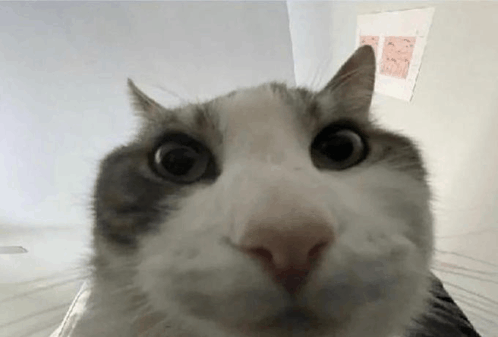

In [18]:
img = Image.open('img/catto.png').convert("RGB")
display(img)


Note-to-self:

transpose matrix:
image_features:[1, 512]
text_features [4, 512](4 labels)
To multiply them, the inner dimensions must match --> single row with 4 scores—one for each label

In [ ]:
#labels = ["a cat sitting", "a dog in a park", "a high-tech office", "a delicious pizza"]
#labels = ["book on a table", "dog in a park", "a high-tech office", "a delicious pizza"]
labels = ["a cat meme", "a happy cat", "a confused cat", "a catgirl"]

text = tokenizer(labels)

image_input = preprocess(img).unsqueeze(0)

with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text)
    
    # normalize
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    
    # calculate cosine similarity --> how close are the features in question?
    # multiply by 100 to make the differences more pronounced
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    
    
print("Predictions:")
for label, prob in zip(labels, text_probs[0]):
    print(f"{label}: {prob:.2%}")

Predictions:
a cat meme: 5.88%
a happy cat: 1.40%
a confused cat: 92.72%
a catgirl: 0.00%
